##**Sensing, Perception, and Actuation Course**

**Primary Instructor: Ilya Afanasyev**

**TA: Karam Almaghout**

**Lab 5, 1 Dec. 2022**

## Camera calibration



!wget "https://www.dropbox.com/s/5z6mml6hy6yeqli/imgs.zip?dl=0" -O imgs.zip
!wget "https://www.dropbox.com/s/7g09unvg8b6bb54/imgs_2.zip?dl=0" -O imgs_2.zip

!unzip imgs.zip -d imgs
!unzip imgs_2.zip -d imgs_2

In [9]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt



In [10]:
square_size = 20
img_mask = "imgs/*.jpg"
pattern_size = (26, 18)

figsize = (20, 20)


In [11]:

img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size
obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]



## Step 1: find all corners in calibration plane


processing imgs\20221201_131400.jpg... 


C:\Users\olego\AppData\Local\Temp\ipykernel_1452\1035773550.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


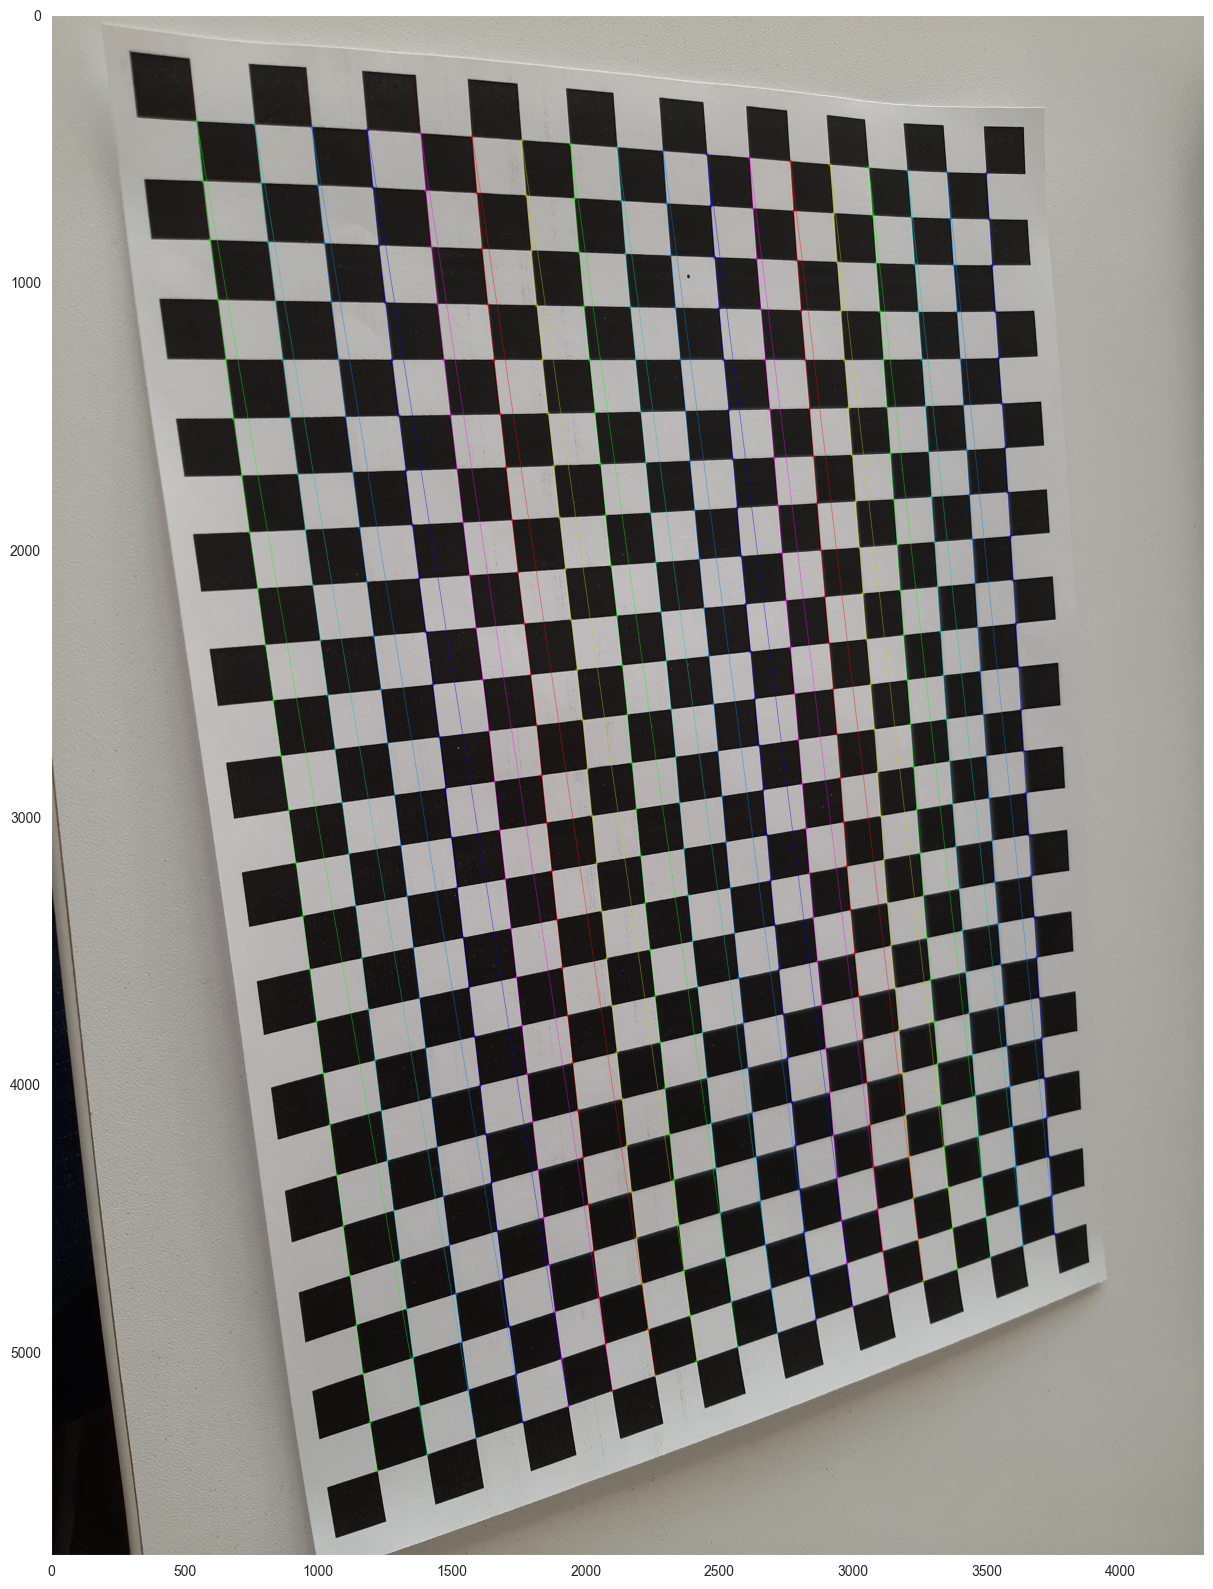

imgs\20221201_131400.jpg... OK
processing imgs\20221201_131409.jpg... 


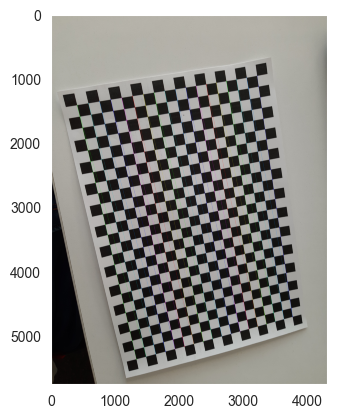

imgs\20221201_131409.jpg... OK
processing imgs\20221201_131417.jpg... 


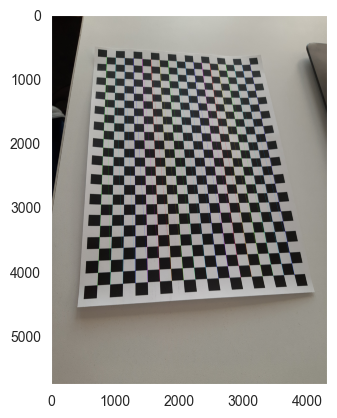

imgs\20221201_131417.jpg... OK
processing imgs\20221201_131429.jpg... 


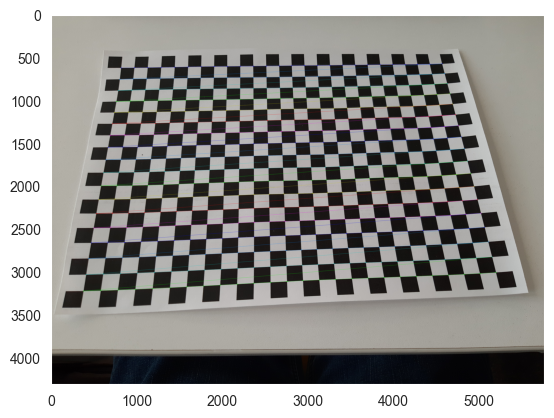

imgs\20221201_131429.jpg... OK


In [12]:
plt.figure(figsize=figsize)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i, fn in enumerate(img_names):
    print("processing %s... " % fn)
    imgBGR = cv2.imread(fn)

    if imgBGR is None:
        print("Failed to load", fn)
        continue

    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(imgRGB, cv2.COLOR_BGR2GRAY)

    # Finds the positions of internal corners of the chessboard.
    # image	Source chessboard view. It must be an 8-bit grayscale or color image.
    # patternSize	Number of inner corners per a chessboard row and column.
    # corners	Output array of detected corners.

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if not found:
        print("chessboard not found")
        continue
    # refining pixel coordinates for given 2d points.
    corners2 = cv2.cornerSubPix(img, corners, (5,5),(-1,-1), criteria)
      

    # Draw and display the corners  

    img_w_corners = cv2.drawChessboardCorners(imgRGB, pattern_size, corners2, found)
    plt.plot()
    plt.grid(b=None)
    plt.imshow(img_w_corners)
    plt.show()

    print(f"{fn}... OK")
    img_points.append(corners2)
    obj_points.append(pattern_points)






## Step 2: get camera intrinsics + distortion coeffs
also get extrinsic rotation and translation vectors per image. Rotation vector is another representation for a full R matrix
more on it here: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula


In [13]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())




RMS: 13.481865525108132
camera matrix:
 [[5.30982287e+03 0.00000000e+00 2.85978315e+03]
 [0.00000000e+00 5.54580058e+03 2.60534176e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [-0.06616832  0.38634416 -0.01619905  0.00251303 -0.53347002]


In [14]:
mean_error = 0
for i in range(len(obj_points)):
    imgpoints2 = cv2.projectPoints(obj_points[i],  _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    error = cv2.norm(img_points[i].reshape(-1,1,2), imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error


print( "total error: {}".format(mean_error/len(obj_points)) )

total error: 0.6123918842650976


## Build undistorted images


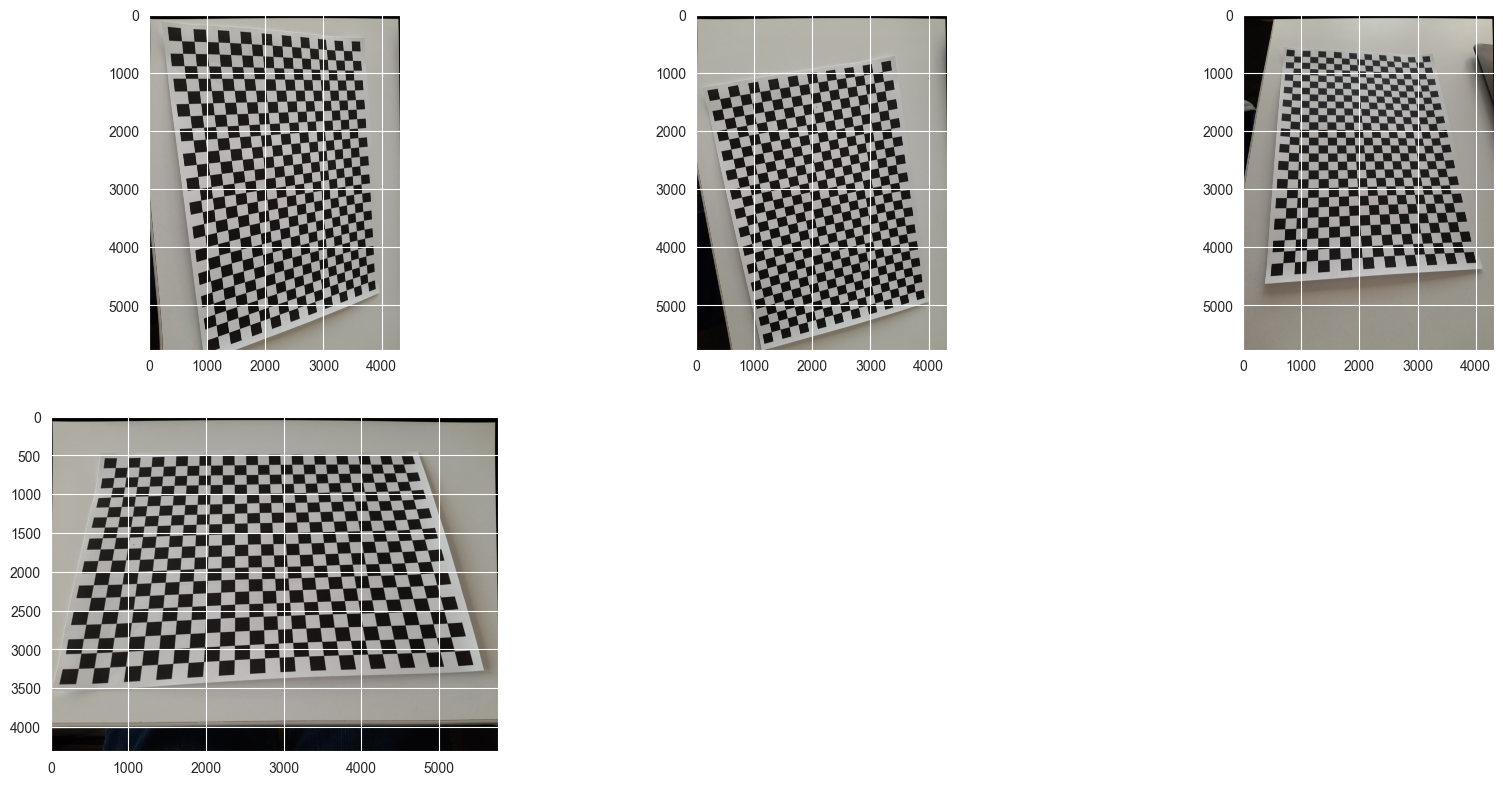

Done


In [15]:
# undistort the image with the calibration
plt.figure(figsize=figsize)
for i, fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)

    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.imshow(dst)

plt.show()
print("Done")



## Example for full projection from 3D to 2D of a cube


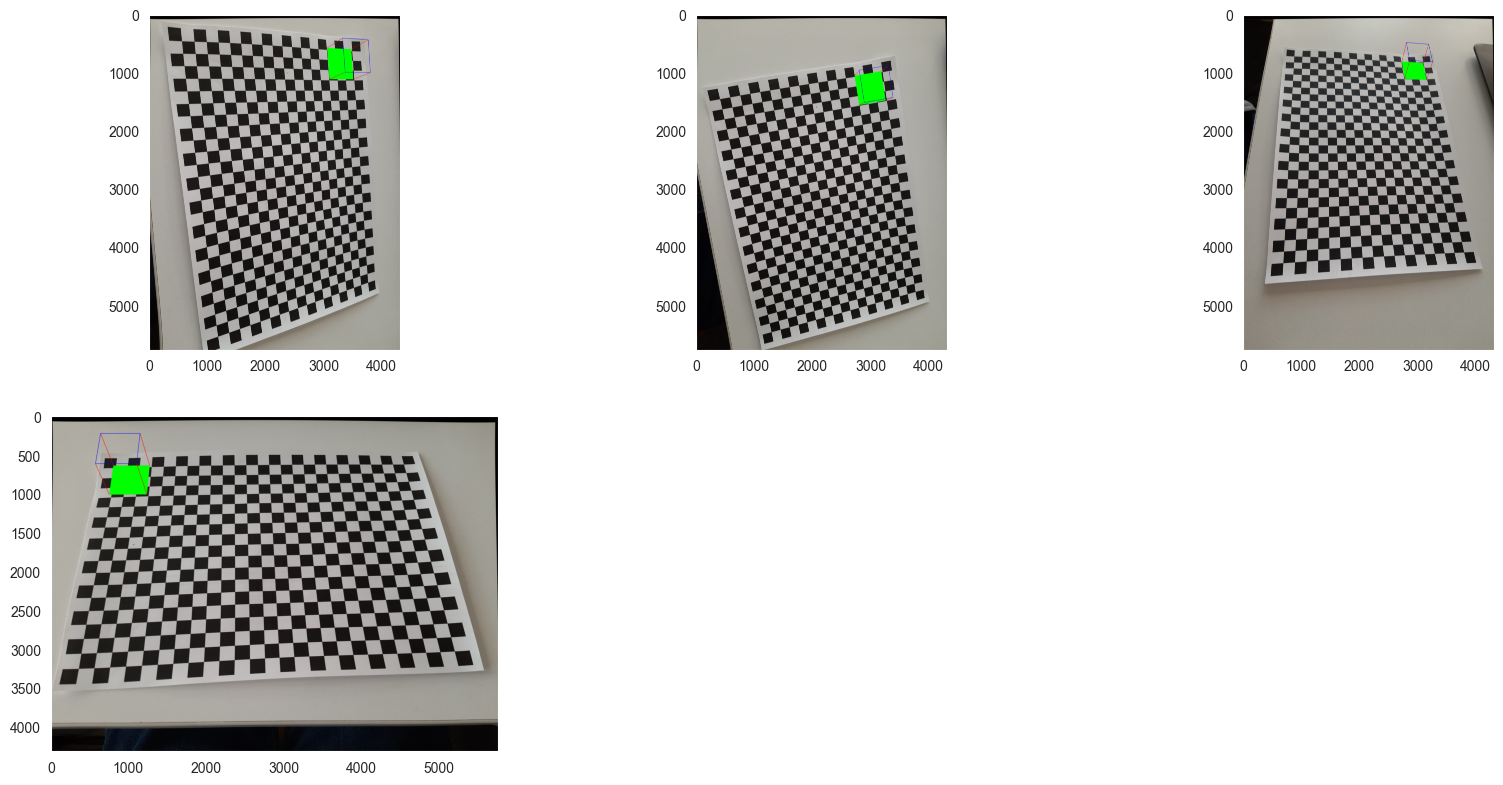

In [19]:
objectPoints =(3*square_size* np.array([[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 0], [0, 0, -1], [0, 1, -1], [1, 1, -1], [1, 0, -1]], dtype=np.float32))


def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -1)

    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img


plt.figure(figsize=figsize)
for i in range(min(len(img_names),len(_rvecs))):

    imgBGR = cv2.imread(img_names[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    imgpts = cv2.projectPoints(objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = draw(dst, imgpts)

    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.grid(visible=False)
        plt.imshow(drawn_image)

plt.show()
